In [3]:
from synutility.SynIO.data_type import load_from_pickle
import networkx as nx
from math import isclose
import time
import numpy as np

from create_partitions_by_invariant import create_partitions_by_invariant
from cluster_reaction_centers import cluster_reaction_centers

In [4]:
def aggregate_charge_and_element_attributes(reaction):
    for node, attributes in reaction.nodes.data():
        attributes["element_charge"] = f"{attributes['element']}{attributes['charge']}"

    return reaction

data = load_from_pickle("/home/mark/Documents/graph_theory/ITS_graphs.pkl.gz")
reactions = [reaction["ITS"] for reaction in data]
reactions = [aggregate_charge_and_element_attributes(reaction) for reaction in reactions]

In [3]:
def edge_count_invariant(reaction_center, partition_representant_reaction_center):
    edge_count_reaction_center = len(reaction_center.edges)
    edge_count_partition_representant = len(partition_representant_reaction_center.edges)

    return edge_count_reaction_center == edge_count_partition_representant

In [4]:
def vertex_count_invariant(reaction_center, partition_representant_reaction_center):
    vertex_count_reaction_center = len(reaction_center.nodes)
    vertex_count_partition_representant = len(partition_representant_reaction_center.nodes)

    return vertex_count_reaction_center == vertex_count_partition_representant

In [5]:
# TODO: check if this implementation for degree invariant is actually correct

def vertex_degree_invariant(reaction_center, partition_representant_reaction_center):
    reaction_center_degrees = sorted([degree for node, degree in list(reaction_center.degree)])
    partition_representant_degrees = sorted([degree for node, degree in list(partition_representant_reaction_center.degree)])

    return reaction_center_degrees == partition_representant_degrees

In [6]:
def algebraic_connectivity_invariant(reaction_center, partition_representant_reaction_center):
    algebraic_connectivity_reaction_center = nx.algebraic_connectivity(reaction_center)
    algebraic_connectivity_partition_representant_reaction_center = nx.algebraic_connectivity(partition_representant_reaction_center)

    return isclose(algebraic_connectivity_reaction_center, algebraic_connectivity_partition_representant_reaction_center, rel_tol=1e-6)

In [7]:
def rank_invariant(reaction_center, partition_representant_reaction_center):
    reaction_center_rank = float(np.linalg.matrix_rank(nx.to_pandas_adjacency(reaction_center).values))
    partition_representant_rank = float(np.linalg.matrix_rank(nx.to_pandas_adjacency(partition_representant_reaction_center).values))

    return isclose(reaction_center_rank, partition_representant_rank, rel_tol=1e-6)

In [8]:
def weisfeiler_lehman_invariant(reaction_center, partition_representant_reaction_center):  
    edge_attribute = 'order'
    node_attribute = 'element_charge'

    reaction_center_hash = nx.weisfeiler_lehman_graph_hash(reaction_center, edge_attr=edge_attribute, node_attr=node_attribute, iterations = 1)
    partition_representant_hash = nx.weisfeiler_lehman_graph_hash(partition_representant_reaction_center, edge_attr=edge_attribute, node_attr=node_attribute, iterations = 1)

    return reaction_center_hash == partition_representant_hash

In [9]:
def av_length_invariant(reaction_center, partition_representant_reaction_center):
    if nx.is_connected(reaction_center) and nx.is_connected(partition_representant_reaction_center):
        avg_path_length_reaction_center = nx.average_shortest_path_length(reaction_center)
        avg_path_length_partition_representant = nx.average_shortest_path_length(partition_representant_reaction_center)

        return isclose(avg_path_length_reaction_center, avg_path_length_partition_representant, rel_tol=1e-6)
    else:
        return True

In [ ]:
def graph_diameter_invariant(reaction_center, partition_representant_reaction_center):
    if nx.is_connected(reaction_center) and nx.is_connected(partition_representant_reaction_center):
        reaction_center_diameter = nx.diameter(reaction_center)
        partition_representant_reaction_center_diameter = nx.diameter(partition_representant_reaction_center)

        return reaction_center_diameter == partition_representant_reaction_center_diameter
    else:
        return True


In [10]:
start_time = time.time()

invariant_check_function = av_length_invariant
pre_filtered_partitions = create_partitions_by_invariant(reactions, invariant_check_function)

overall_partitions = []

for pre_filtered_partition in pre_filtered_partitions:
        partitions = cluster_reaction_centers(pre_filtered_partition)
        overall_partitions = overall_partitions + partitions

end_time = time.time()

# Summary

In [14]:
elapsed_time = end_time - start_time

print(f"Time elapsed: {elapsed_time:.2f} seconds")

print(f"Partitions found: {len(pre_filtered_partitions)}")

Time elapsed: 114.58 seconds
Partitions found: 52


IndexError: list index out of range

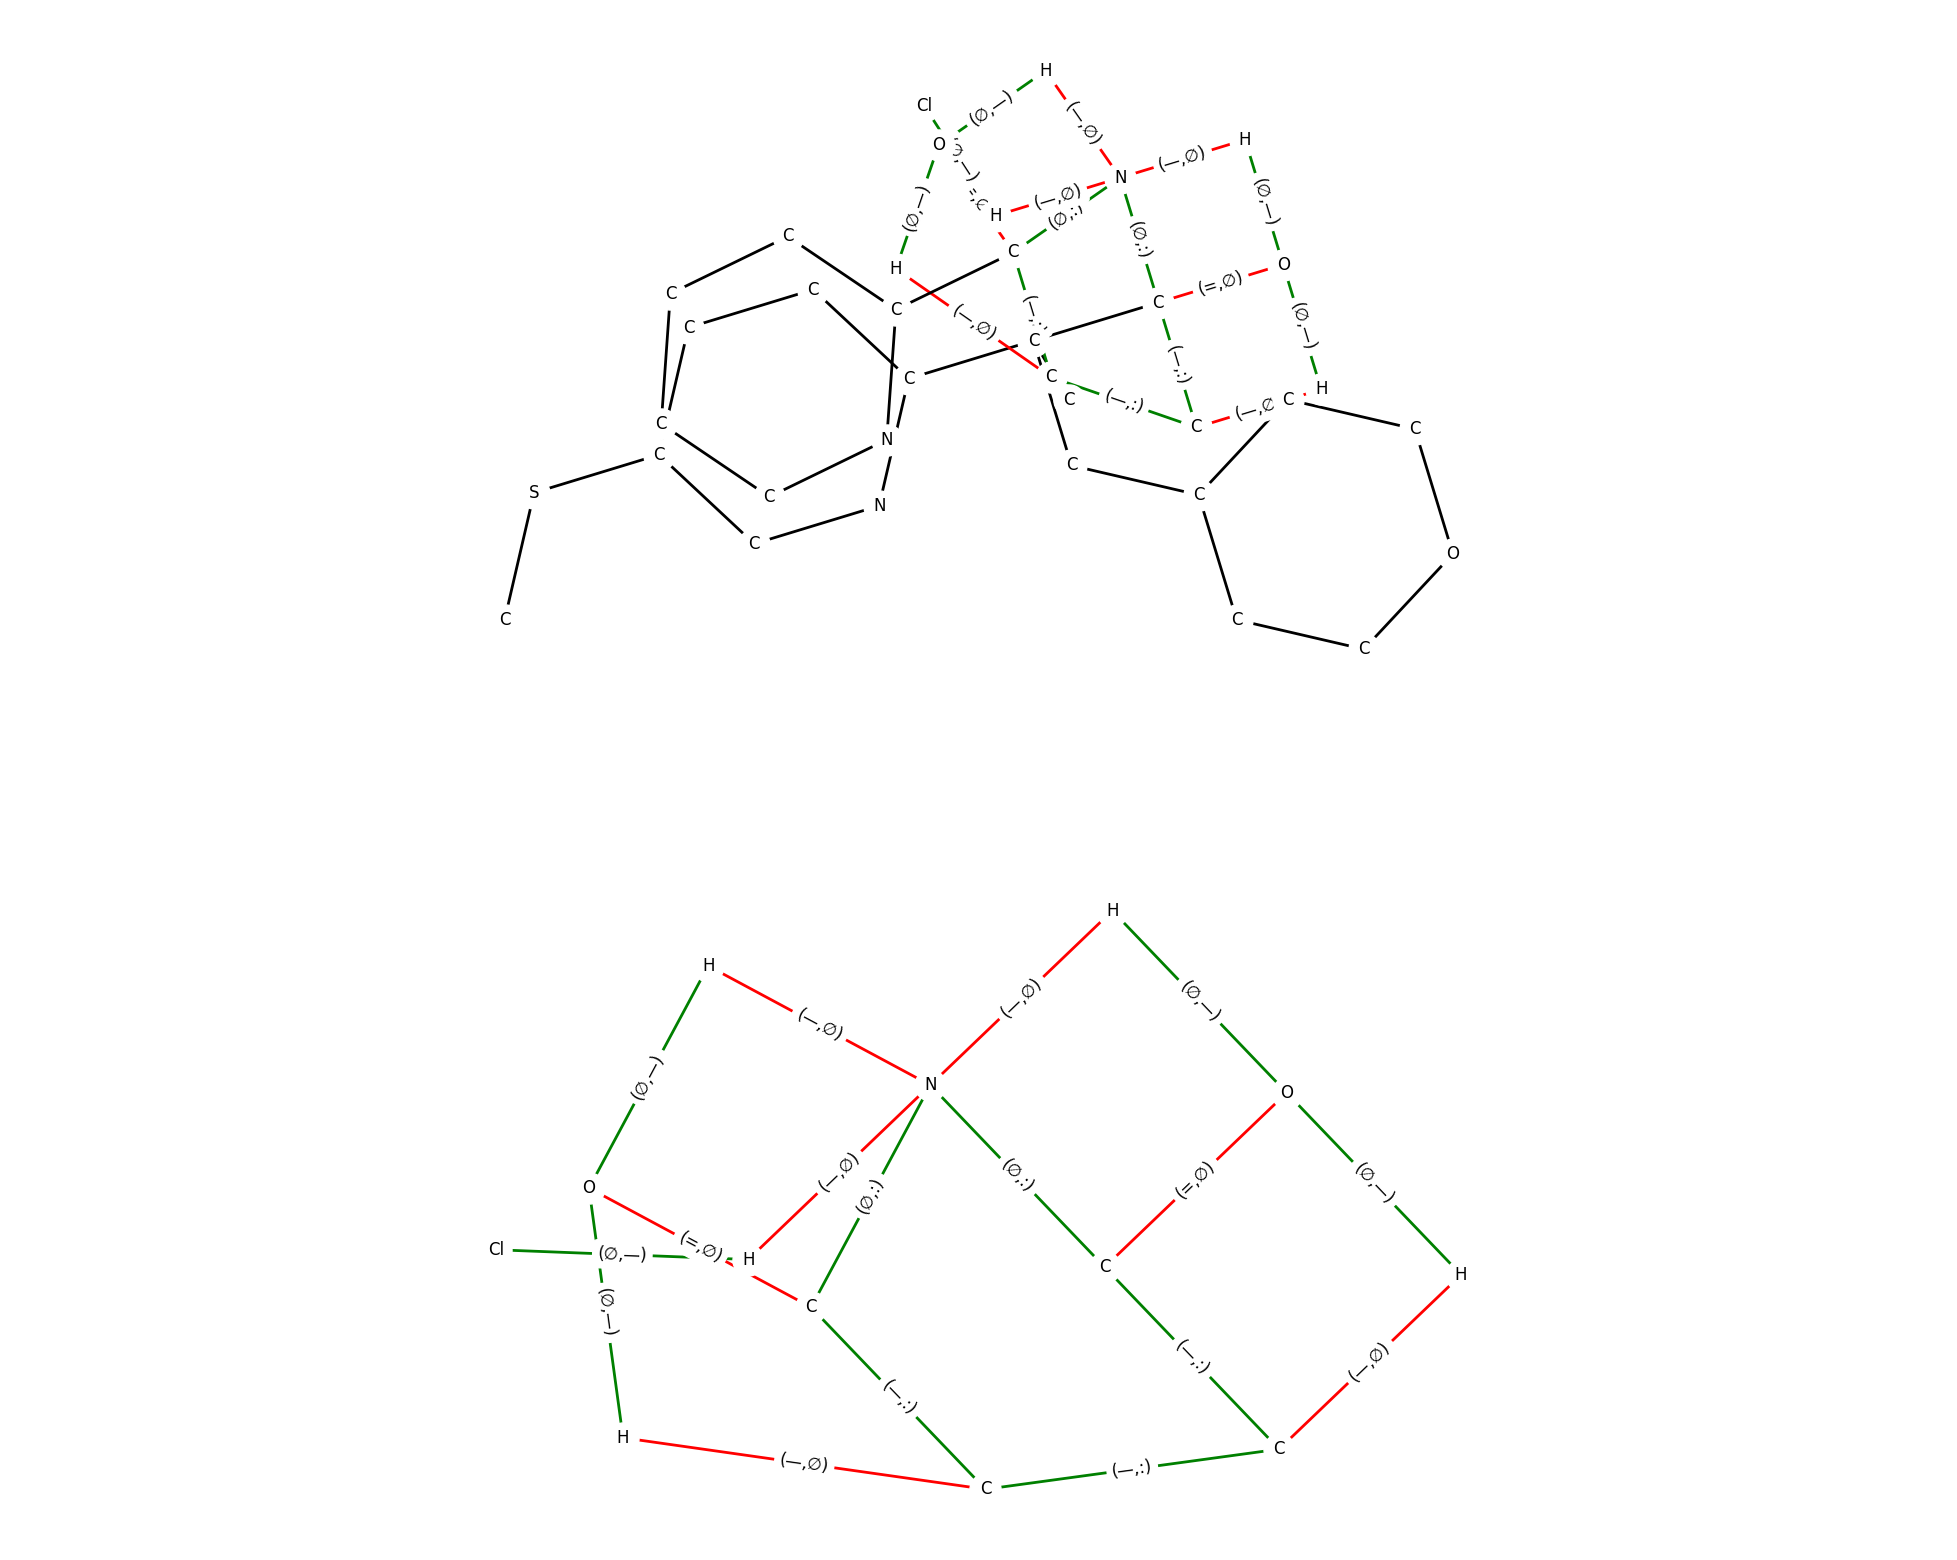

In [12]:
from visualize_graph import visualize_graph

current_partition = partitions[0]

visualize_graph(current_partition[0], with_reaction_center=True)
visualize_graph(current_partition[1], with_reaction_center=True)

# multistage invariant partitioning / hierarchical clustering

In [40]:
""" invariant_config = {
    0: edge_count_invariant,
    1: vertex_degree_invariant,
    2: weisfeiler_lehman_invariant 
} """

""" invariant_config = {
    0: rank_invariant,
    1: vertex_count_invariant,
    2: edge_count_invariant,
    3: vertex_degree_invariant,
    4: weisfeiler_lehman_invariant 
} """


""" invariant_config = {
    0: vertex_count_invariant,
    1: edge_count_invariant,
    2: vertex_degree_invariant,
    3: rank_invariant,
    4: weisfeiler_lehman_invariant 
} 
 """

invariant_config = {
    0: edge_count_invariant,
}

In [ ]:
partitions = []

start_time = time.time()

for invariant_index in range(0, len(invariant_config.values())):
    invariant_check_function = invariant_config[invariant_index]

    if invariant_index == 0:
        partitions = create_partitions_by_invariant(reactions, invariant_check_function)
    else:
         for index, partition in enumerate(partitions):
            del partitions[index]
            
            sub_partitions = create_partitions_by_invariant(partition, invariant_check_function)

            partitions = partitions + sub_partitions

    print(f"{invariant_index}'s partition length = {len(partitions)}")

overall_partitions = []

for pre_filtered_partition in partitions:
    p = cluster_reaction_centers(pre_filtered_partition)
    overall_partitions = overall_partitions + p 

end_time = time.time()

- After each prepartitioning the usual nx.isomorphism check must be executed
- the goal is to optimally reduce the complete runtime by prepartitioning

In [ ]:
elapsed_time = end_time - start_time

print(f"Time elapsed: {elapsed_time:.2f} seconds")

print(f"Partitions via invariants found: {len(partitions)}")
print(f"Partitions finally found: {len(overall_partitions)}")

In [15]:
number_of_elements_per_cluster = [(index, len(p)) for index, p in enumerate(partitions)]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = number_of_elements_per_cluster
sorted_data = sorted(data, key=lambda x: x[1])

original_indices_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(32, 20))
plt.bar(range(len(values_sorted)), values_sorted, tick_label=original_indices_sorted, color='lightgreen', edgecolor='black')
plt.xlabel('Original Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Barplot with Values Sorted but Original Indices Shown', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
one_element_partitions = [p for p in number_of_elements_per_cluster if p[1] < 2]

len(one_element_partitions)

one_element_partitions[0]


In [ ]:
example_graph = partitions[one_element_partitions[7][0]][0]

visualize_graph(example_graph, with_reaction_center=True)

In [ ]:
two_element_partitions = [p for p in number_of_elements_per_cluster if p[1] == 2]

len(two_element_partitions)

two_element_partitions

example_graphs = partitions[two_element_partitions[0][0]]

visualize_graph(example_graphs[0], with_reaction_center=True)
visualize_graph(example_graphs[1], with_reaction_center=True)


In [7]:
from itertools import combinations
from invariants import edge_count_invariant, vertex_count_invariant, rank_invariant, vertex_degree_invariant, global_clustering_invariant, av_length_invariant, graph_diameter_invariant, graph_girth_invariant


fns = [
    edge_count_invariant, 
    vertex_count_invariant,
    vertex_degree_invariant,
    rank_invariant,
    global_clustering_invariant,
    av_length_invariant,
    graph_diameter_invariant,
    graph_girth_invariant
]

# Generate all unique pairwise tuples
pairwise_tuples = list(combinations(fns, 2))

x = [{0: one, 1: two, 2: weisfeiler_lehman_invariant} for one, two in pairwise_tuples]


NameError: name 'weisfeiler_lehman_invariant' is not defined

In [13]:
import time
from create_partitions_by_invariant import create_partitions_by_invariant
from cluster_reaction_centers import cluster_reaction_centers
from synutility.SynIO.data_type import load_from_pickle
from invariant_combinations import invariant_combinations
import random

from invariants import edge_count_invariant, global_clustering_invariant, graph_diameter_invariant, graph_girth_invariant, rank_invariant, vertex_degree_invariant, weisfeiler_lehman_invariant, vertex_count_invariant, av_length_invariant

random.shuffle(invariant_combinations)

invariant_combinations = [
    {
        0: edge_count_invariant,
        1: vertex_degree_invariant,
        2: av_length_invariant,
        3: graph_diameter_invariant,
        4: weisfeiler_lehman_invariant
    },
    {
        0: edge_count_invariant,
        1: vertex_degree_invariant,
        2: av_length_invariant,
        3: graph_girth_invariant,
        4: weisfeiler_lehman_invariant
    },
    {
        0: edge_count_invariant,
        1: vertex_degree_invariant,
        2: av_length_invariant,
        3: global_clustering_invariant,
        4: weisfeiler_lehman_invariant
    },
]


# vertex-invariant = 299 partitions
# vertex and edge count = 167 partitions
# weisfeiler lehman = 299 partitions
# vertex count and weisfeiler lehman = 353 partitions

def aggregate_charge_and_element_attributes(reaction):
    for node, attributes in reaction.nodes.data():
        attributes["element_charge"] = f"{attributes['element']}{attributes['charge']}"

    return reaction

def load_reactions():
    data = load_from_pickle("/home/mark/Documents/graph_theory/ITS_graphs.pkl.gz")
    reactions = [reaction["ITS"] for reaction in data]
    reactions = [aggregate_charge_and_element_attributes(reaction) for reaction in reactions]

    return reactions

if __name__ == "__main__":
    reactions = load_reactions()
    partitions = []

    for invariant_config_index, invariant_config in enumerate(invariant_combinations):

        complete_start_time = time.time()

        for invariant_index in range(0, len(invariant_config.values())):
            invariant_check_function = invariant_config[invariant_index]

            start_invariant = time.time()

            start_partition_assign = None
            end_partition_assign = None

            if invariant_index == 0:
                partitions = create_partitions_by_invariant(reactions, invariant_check_function)
            else:
                all_sub_partitions = []
                for index, partition in enumerate(partitions):
                    sub_partitions = create_partitions_by_invariant(partition, invariant_check_function)

                    all_sub_partitions = all_sub_partitions + sub_partitions

                partitions = all_sub_partitions

            end_invariant = time.time()
            
            print(f"{invariant_index}'s partition length = {len(partitions)}")
            print(f"{invariant_index}'s time = {(end_invariant - start_invariant):.2f}")
            
        pre_filtering_end_time = time.time()
        overall_partitions = []

        for pre_filtered_partition in partitions:
            p = cluster_reaction_centers(pre_filtered_partition)
            overall_partitions = overall_partitions + p 

        complete_end_time = time.time()

        complete_elapsed_time = complete_end_time - complete_start_time
        prefiltering_elapsed_time = pre_filtering_end_time - complete_start_time
        print(f"###Invariant Config ###")
        print(invariant_config)

        print(f"Time elapsed pre: {prefiltering_elapsed_time:.2f} seconds")
        print(f"Time elapsed complete: {complete_elapsed_time:.2f} seconds")

        print(f"Partitions via invariants found: {len(partitions)}")
        print(f"Partitions finally found: {len(overall_partitions)}")
        print("#########################################")

0's partition length = 16
0's time = 4.41
1's partition length = 57
1's time = 3.86
2's partition length = 71
2's time = 7.53
3's partition length = 71
3's time = 6.90
4's partition length = 299
4's time = 47.38
###Invariant Config ###
{0: <function edge_count_invariant at 0x7d0ea6a4b2e0>, 1: <function vertex_degree_invariant at 0x7d0ea6a4b560>, 2: <function av_length_invariant at 0x7d0ea6a4b600>, 3: <function graph_diameter_invariant at 0x7d0ea6a4b740>, 4: <function weisfeiler_lehman_invariant at 0x7d0ea6a4b420>}
Time elapsed pre: 70.07 seconds
Time elapsed complete: 86.74 seconds
Partitions via invariants found: 299
Partitions finally found: 299
#########################################
0's partition length = 16
0's time = 4.42
1's partition length = 57
1's time = 3.85
2's partition length = 71
2's time = 7.29
3's partition length = 74
3's time = 6.35
4's partition length = 299
4's time = 48.69
###Invariant Config ###
{0: <function edge_count_invariant at 0x7d0ea6a4b2e0>, 1: <functio

In [6]:
len(reactions)

34395

In [31]:
def get_nodes_element_lookup(graph):
    return {node: attributes["element"] for node, attributes in graph.nodes.data()}

def weisfeiler_leman_1_new(graph):
    element_lookup = get_nodes_element_lookup(graph)

    c1 = {}
    for node_label in graph.nodes:
        c1[node_label] = 1 

    for iteration in range(1): 
        l1 = {}
        for node_label in graph.nodes:
            neighbours1 = graph.neighbors(node_label)
            l1[node_label] = (
                c1[node_label],
                [c1[neighbour_label] for neighbour_label in neighbours1],
            )
        c1_new = {}
        for key in c1.keys():
            l1_values = l1[key]
            h1 = hash((l1_values[0], tuple(sorted(l1_values[1]))))  
            c1_new[key] = h1
        c1 = c1_new
    
    hash_dict = {}
    for node, h in c1.items():  
        if h not in hash_dict:
            hash_dict[h] = {"count": 0, "nodes": []}
        hash_dict[h]["count"] += 1
        hash_dict[h]["nodes"].append(element_lookup[node])

    return {"graph": graph, "hash": hash_dict}

In [27]:
for index, reaction in enumerate(reactions):
    rc = get_reaction_center(reaction)

    if len(rc.nodes) > 4:
        print(index)
    

10
21
30
41
48
75
76
83
90
91
92
103
115
118
121
126
131
135
136
138
139
147
149
152
162
163
167
184
187
189
196
201
216
223
233
244
245
252
256
259
261
267
270
282
293
300
307
314
320
326
337
373
374
377
387
394
402
412
417
418
421
425
426
436
440
444
446
451
458
467
483
484
501
517
518
520
526
533
538
545
563
564
568
589
603
613
614
644
647
655
663
674
679
681
682
684
685
693
698
699
701
703
708
710
719
721
725
726
734
738
749
750
779
784
785
787
789
791
795
800
806
815
819
820
825
847
849
850
854
857
859
862
867
872
875
881
886
904
906
908
923
931
935
944
949
964
971
978
986
1006
1008
1035
1042
1046
1058
1059
1062
1067
1068
1069
1079
1084
1092
1102
1105
1115
1118
1124
1133
1153
1157
1162
1169
1175
1177
1179
1181
1187
1194
1209
1212
1223
1224
1231
1234
1235
1240
1245
1247
1254
1258
1267
1277
1282
1285
1293
1304
1306
1308
1309
1316
1317
1326
1329
1337
1342
1351
1369
1382
1397
1405
1423
1426
1427
1434
1438
1459
1463
1476
1479
1483
1485
1489
1527
1536
1538
1545
1566
1580
1587
1591
1595


In [ ]:
def get_nodes_element_lookup(graph):
    return {node: attributes["element"] for node, attributes in graph.nodes.data()}

def weisfeiler_leman_with_convergence(graph):
    element_lookup = get_nodes_element_lookup(graph)

    c1 = {}
    for node_label in graph.nodes:
        c1[node_label] = 1 

    for iteration in range(1): 
        l1 = {}
        for node_label in graph.nodes:
            neighbours1 = graph.neighbors(node_label)
            l1[node_label] = (
                c1[node_label],
                [c1[neighbour_label] for neighbour_label in neighbours1],
            )
        c1_new = {}
        for key in c1.keys():
            l1_values = l1[key]
            h1 = hash((l1_values[0], tuple(sorted(l1_values[1]))))  
            c1_new[key] = h1
        c1 = c1_new
    
    hash_dict = {}
    for node, h in c1.items():  
        if h not in hash_dict:
            hash_dict[h] = {"count": 0, "nodes": []}
        hash_dict[h]["count"] += 1
        hash_dict[h]["nodes"].append(element_lookup[node])

    return {"graph": graph, "hash": hash_dict}

In [33]:
from get_reaction_center import get_reaction_center

rc1 = get_reaction_center(reactions[0])

weisfeiler_leman_1_new(rc1)

{'graph': <networkx.classes.graph.Graph at 0x788e86785ed0>,
 'hash': {-689149142803208733: {'count': 4, 'nodes': ['H', 'N', 'C', 'Br']}}}

In [34]:
from get_reaction_center import get_reaction_center

rc2 = get_reaction_center(reactions[2])

weisfeiler_leman_1_new(rc2)

{'graph': <networkx.classes.graph.Graph at 0x788e843c54d0>,
 'hash': {-689149142803208733: {'count': 4, 'nodes': ['C', 'Cl', 'N', 'H']}}}

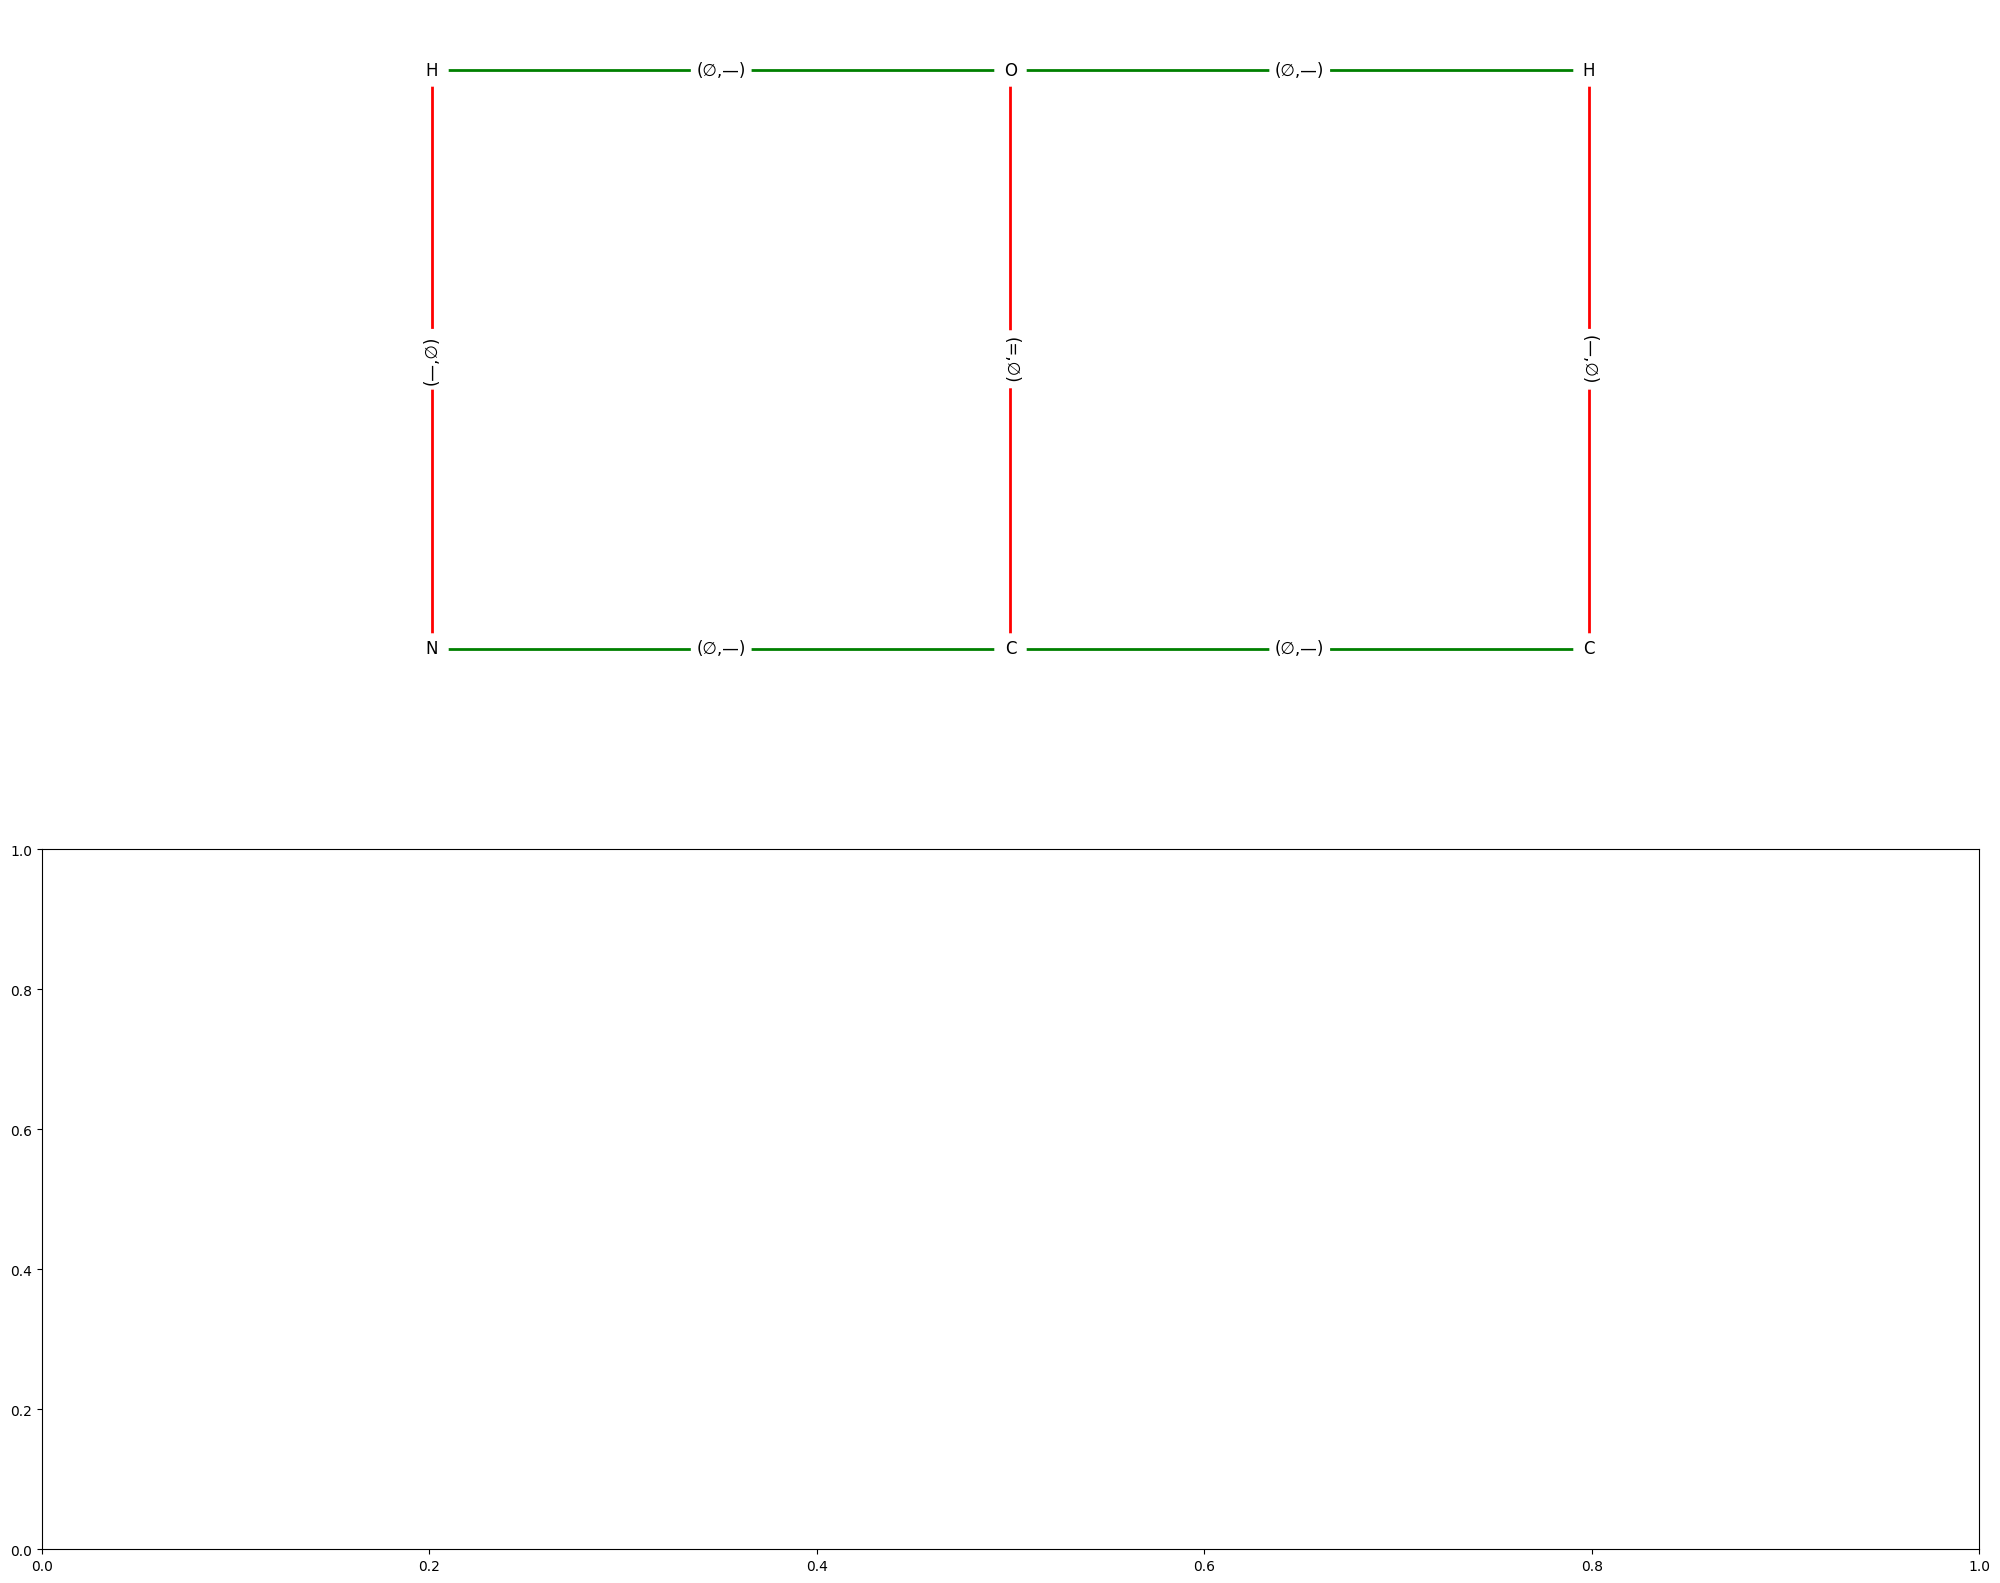

In [29]:
from visualize_graph import visualize_graph

visualize_graph(rc, with_reaction_center=False)